In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from IPython.display import display, Math
from astropy import units as u

from mcmc_reg import PiecewiseConstSpectralModel, run_mcmc_with_reg, plot_corner, plot_trace, get_dnde
from gammapy.datasets import SpectrumDatasetOnOff
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, Models
from gammapy.modeling import Fit

In [2]:
# Geminga pulsar, the second pulsed emission peak P2
# Detailed reduction process can be found in data_reduction/data_reduction_geminga.ipynb
# Here use the stacked (averaged IRFs) dataset

dataset00 = SpectrumDatasetOnOff.read("../Dataset_reduced/GemingaP2_dataset00_stacked.fits")


# Spectrum fitting (Power-law)

In [3]:
# Initialize the model # pwl fit (the fitted amplitude will be set to the stepped pwl model)
spectral_model = PowerLawSpectralModel(
    amplitude=1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    index=5,
    reference=32.15 * u.GeV,
)
model = SkyModel(spectral_model=spectral_model, name="gemingaP2_pwl")
dataset00.models = [model]

fit_pwl=Fit()
result_pwl = fit_pwl.run(datasets=dataset00)
model_pwl = model.copy()

print(result_pwl)
display(result_pwl.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 71
	total stat : 17.26

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str13,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
gemingaP2_pwl,,index,5.1320e+00,,4.241e-01,nan,nan,False,False,,
gemingaP2_pwl,,amplitude,2.4881e-09,TeV-1 s-1 cm-2,6.176e-10,nan,nan,False,True,,
gemingaP2_pwl,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,False,,


In [4]:
# True energy axis (set before in data reduction)
eval = dataset00.evaluators['gemingaP2_pwl']
true_ene_edges = eval.geom.axes["energy_true"].edges

# centers of true energy bins
true_ene_cntr = []
for emin, emax in list(zip(true_ene_edges[:-1], true_ene_edges[1:])):
    ecntr = np.sqrt(emin*emax)
    true_ene_cntr.append(ecntr)

true_ene_cntr = u.Quantity(true_ene_cntr)

print(f"True E edges:\n {true_ene_edges}")
print(f"True E centers:\n {true_ene_cntr}")

True E edges:
 [5.00000000e+00 7.75257890e+00 1.20204959e+01 1.86379686e+01
 2.88984644e+01 4.48075251e+01 6.94747747e+01 1.07721735e+02
 1.67024249e+02 2.58973734e+02 4.01542861e+02 6.22598542e+02
 9.65348864e+02 1.49678865e+03 2.32079442e+03 3.59842837e+03
 5.57941996e+03 8.65097869e+03 1.34134790e+04 2.07978108e+04
 3.22473339e+04 5.00000000e+04] GeV
True E centers:
 [6.22598542e+00 9.65348864e+00 1.49678865e+01 2.32079442e+01
 3.59842837e+01 5.57941996e+01 8.65097869e+01 1.34134790e+02
 2.07978108e+02 3.22473339e+02 5.00000000e+02 7.75257890e+02
 1.20204959e+03 1.86379686e+03 2.88984644e+03 4.48075251e+03
 6.94747747e+03 1.07721735e+04 1.67024249e+04 2.58973734e+04
 4.01542861e+04] GeV


# Stepped pwl model for flux estimation

The differential flux in the **$i$-th true energy bin** is
$$ \phi_i(E) = \mathrm{norm}_i \cdot f_0 \cdot \left(\frac{E}{E_0} \right)^{-2} $$

$E_0$ is the reference energy

$f_0$ is the reference flux, which can be set to the previous best-fit value

$\mathrm{norm}_i$ is the corresponding **free normalization parameter**, which is an estimate of the flux point.

In [5]:
# Stepped pwl model
source_amp = model_pwl.copy().spectral_model.amplitude
spectral_model = PowerLawSpectralModel(index=2.0, amplitude=source_amp, reference=32.15*u.GeV)
spectral_model.index.frozen = True
spectral_model.amplitude.frozen = True

Piecewise_const = PiecewiseConstSpectralModel(energy_edges = true_ene_edges)

# selecting an energy range that covers bins with significant excess counts
for idx in range(len(true_ene_cntr)):
    Piecewise_const.parameters['norm_%i'%idx].min = 1e-3
    Piecewise_const.parameters['norm_%i'%idx].max = 1e+2
    
    if true_ene_edges[:-1][idx] < 12*u.GeV :
        Piecewise_const.parameters['norm_%i'%idx].value = 0
        Piecewise_const.parameters['norm_%i'%idx].frozen = True
    if true_ene_edges[1:][idx] > 100*u.GeV :
        Piecewise_const.parameters['norm_%i'%idx].value = 0
        Piecewise_const.parameters['norm_%i'%idx].frozen = True
        

source = SkyModel(
    spectral_model  = spectral_model * Piecewise_const,
    name="test_source",
)

models = Models([source])
dataset00.models = models

fit_stepped_pwl = Fit(backend='minuit')
result_stepped_pwl = fit_stepped_pwl.run(datasets = dataset00)


# Run MCMC with the optimal regularization depth 


+ `run_mcmc_with_reg(dataset, nwalkers, nrun, threads, reg_depth)`

for Geminga reg_opt=0.684

For detailed information on the method, see Details_and_performance.ipynb

In [6]:
%%time
sampler = run_mcmc_with_reg(dataset00, nwalkers=12, nrun=10000, threads=1, reg_depth=0.684, backend=None)

/home/iwsatlas1/yunhe/miniconda3/envs/gammapy-1.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 9min 53s, sys: 175 ms, total: 9min 53s
Wall time: 9min 53s


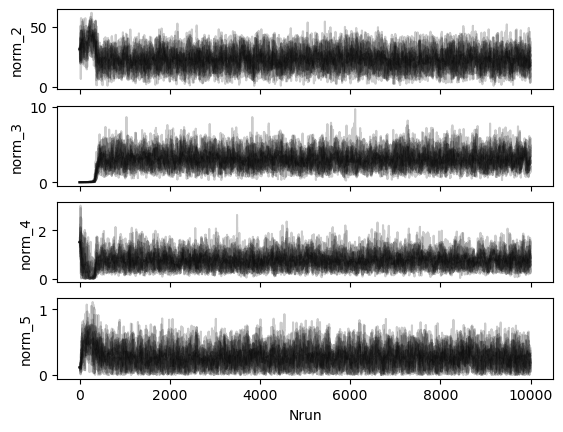

In [7]:
plot_trace(sampler, dataset00)

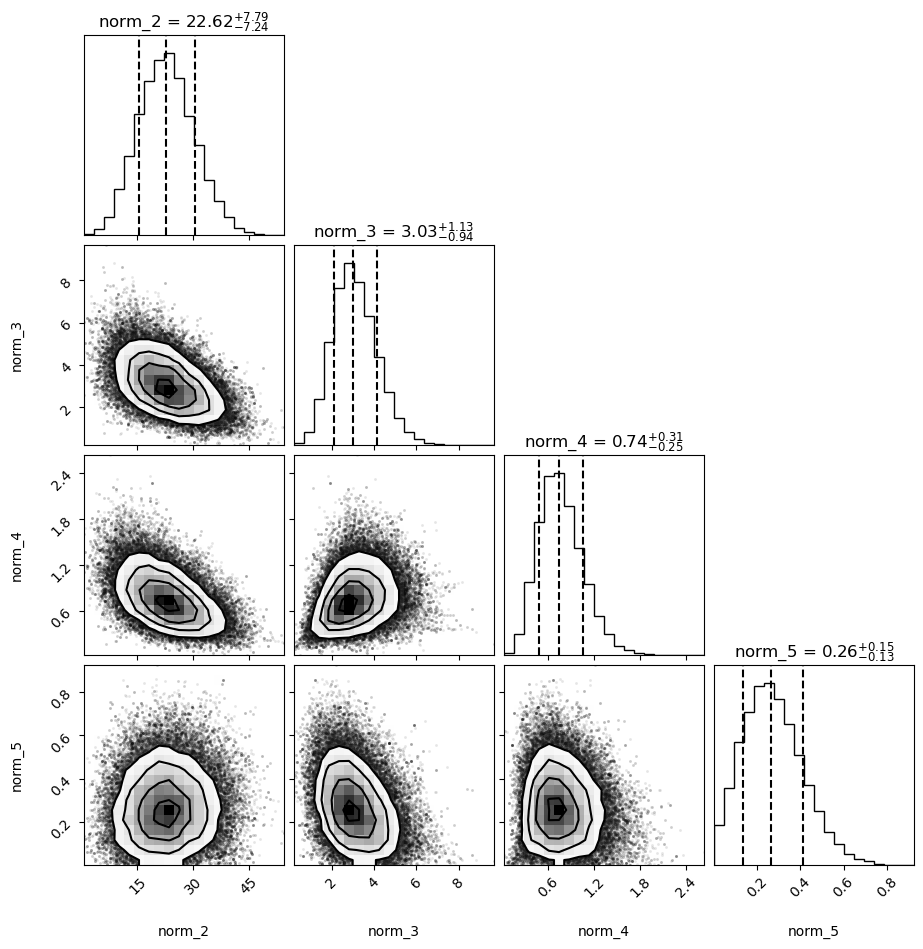

In [8]:
nburn = 1000
plot_corner(sampler, dataset00, nburn)

# SED points

Get differential flux values
+ `get_dnde(sampler, dataset, nburn)`

In [9]:
dnde_arr, dnde_err_minus_arr, dnde_err_plus_arr = get_dnde(sampler, dataset00, nburn)

In [10]:
# differential flux (dnde)
print("dnde: ", dnde_arr)
print("\n dnde_err_minus", dnde_err_minus_arr)
print("\n dnde_err_plus", dnde_err_plus_arr)

# SED (e2dnde)
print("e2dnde: ", dnde_arr * true_ene_cntr.to(u.TeV)**2)
print("\n e2dnde_err_minus", dnde_err_minus_arr * true_ene_cntr.to(u.TeV)**2)
print("\n e2dnde_err_plus", dnde_err_plus_arr * true_ene_cntr.to(u.TeV)**2)

dnde:  [0.00000000e+00 0.00000000e+00 2.59681935e-07 1.44728511e-08
 1.46868191e-09 2.16499765e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1 / (TeV s cm2)

 dnde_err_minus [0.00000000e+00 0.00000000e+00 8.31078209e-08 4.49446313e-09
 5.03471776e-10 1.06909208e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1 / (TeV s cm2)

 dnde_err_plus [0.00000000e+00 0.00000000e+00 8.93865188e-08 5.39974096e-09
 6.22177160e-10 1.23526961e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[]

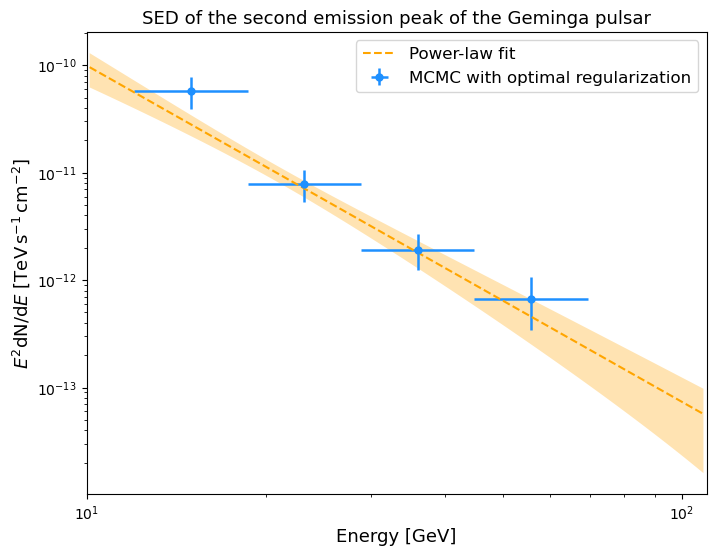

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [10, 110] # unit: GeV

plot_kwargs = {
    "energy_bounds": energy_bounds * u.GeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "ax": ax,
}

ene_err_lower = true_ene_cntr - true_ene_edges[:-1]
ene_err_upper = true_ene_edges[1:] - true_ene_cntr

plt.errorbar(true_ene_cntr, dnde_arr * true_ene_cntr.to(u.TeV)**2, 
             xerr=[ene_err_lower, ene_err_upper], 
            yerr=[dnde_err_minus_arr * true_ene_cntr.to(u.TeV)**2, dnde_err_plus_arr * true_ene_cntr.to(u.TeV)**2], 
             capsize=0, elinewidth=1.8, fmt='o', color='dodgerblue', markersize=5, label="MCMC with optimal regularization")

model_pwl.spectral_model.plot(**plot_kwargs, color='orange',ls='--',label="Power-law fit")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="orange", alpha=0.3)

ax.set_xlim(energy_bounds)
ax.set_xlabel("Energy [GeV]", fontsize=13)
ax.set_ylabel(r"$E^2$dN/d$E$ $\mathrm{[TeV \, s^{-1} \, cm^{-2}]}$", fontsize=13)
plt.title('SED of the second emission peak of the Geminga pulsar', fontsize=13)
plt.legend(fontsize=12)
plt.loglog()

# Correlation matrix between the spectral points

In [12]:
# covariance matrix
free_param = dataset00.models.parameters.free_parameters
labels = [par.name for par in free_param]

flat_samples = sampler.get_chain(discard=nburn, flat=True).T
flat_samples_rescale = np.zeros_like(flat_samples)

for i, par in enumerate(free_param):
    flat_samples_rescale[i, :] = flat_samples[i,:] * par.scale

cov_param = np.cov(flat_samples_rescale)

([<matplotlib.axis.YTick at 0x7ff0e796d570>,
 [Text(0, 0, 'norm_2'),
  Text(0, 1, 'norm_3'),
  Text(0, 2, 'norm_4'),
  Text(0, 3, 'norm_5')])

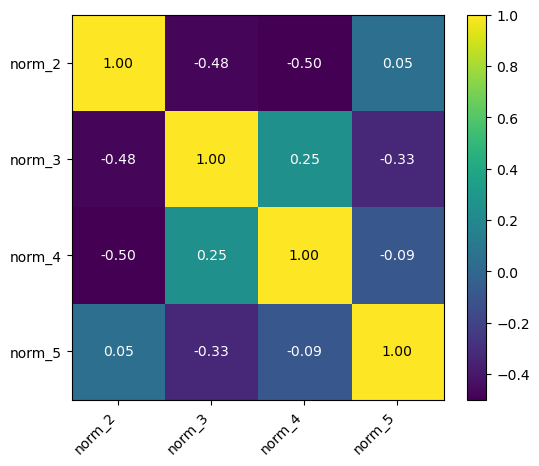

In [13]:
# correlation between spectral points
std = np.sqrt(np.diag(cov_param))

correlation_matrix = cov_param / np.outer(std, std)

plt.figure(figsize=(6,5))
heatmap = plt.imshow(correlation_matrix, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar(heatmap)

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i==j:
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')
        else:
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)